C:\Users\ACER\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.21917878091335297
Epoch 25, Loss: 0.00736402440816164
Epoch 50, Loss: 0.022979846224188805
Epoch 75, Loss: 0.04381011798977852
Epoch 100, Loss: 0.04183589294552803
Epoch 125, Loss: 0.03637826070189476
Final loss: 0.030767764896154404


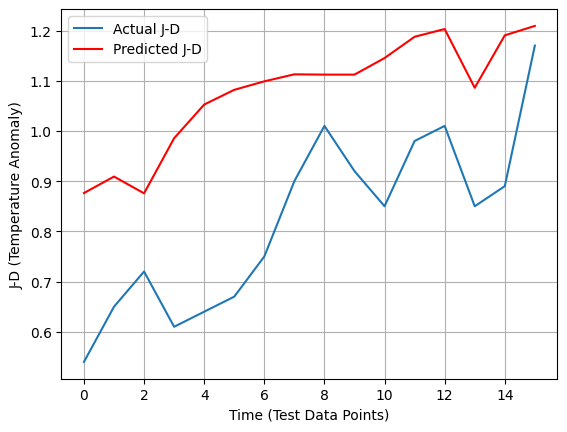

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the CO2 emission data (Year, CO2_Emission (billion metric ton))
co2_data = pd.read_csv('co2emissionGlobalData.csv')

# Load the GLB.Ts+dSST data (Year, J-D values)
jd_data = pd.read_csv('GLB.Ts+dSST.csv', header=1)

# Preprocess the jd_data (replace non-numeric values with NaN and remove them)
jd_data.replace('***', np.nan, inplace=True)
jd_data.dropna(inplace=True)

# Filter both datasets for the years between 1940 and 2023
co2_data = co2_data[(co2_data['Year'] >= 1940) & (co2_data['Year'] <= 2023)]
jd_data = jd_data[(jd_data['Year'] >= 1940) & (jd_data['Year'] <= 2023)]

# Merge the two datasets on the 'Year' column
merged_data = pd.merge(co2_data, jd_data[['Year', 'J-D']], on='Year')

# Extract the CO2 Emission and J-D values
co2_emission = merged_data['CO2_Emission (billion metric ton)'].values.reshape(-1, 1)
jd_values = merged_data['J-D'].values.reshape(-1, 1)

# Normalize the data using MinMaxScaler
scaler_co2 = MinMaxScaler(feature_range=(-1, 1))
scaler_jd = MinMaxScaler(feature_range=(-1, 1))

co2_emission_normalized = scaler_co2.fit_transform(co2_emission)
jd_values_normalized = scaler_jd.fit_transform(jd_values)

# Convert the normalized data into tensors
co2_emission_tensor = torch.FloatTensor(co2_emission_normalized)
jd_values_tensor = torch.FloatTensor(jd_values_normalized)

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(co2_emission_tensor) * 0.8)
test_size = len(co2_emission_tensor) - train_size

train_co2, test_co2 = co2_emission_tensor[:train_size], co2_emission_tensor[train_size:]
train_jd, test_jd = jd_values_tensor[:train_size], jd_values_tensor[train_size:]

# Function to create sequences for LSTM input
def create_sequences(input_data, output_data, window_size):
    inout_seq = []
    L = len(input_data)
    for i in range(L - window_size):
        train_seq = input_data[i:i + window_size]
        train_label = output_data[i + window_size:i + window_size + 1]
        inout_seq.append((train_seq, train_label))
    return inout_seq

# Set the window size for the LSTM model (for simplicity, let's use a window of 1)
window_size = 1
train_inout_seq = create_sequences(train_co2, train_jd, window_size)

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

# Instantiate the model, define the loss function, and the optimizer
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the LSTM model
epochs = 150
for epoch in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if epoch % 25 == 0:
        print(f'Epoch {epoch}, Loss: {single_loss.item()}')

print(f'Final loss: {single_loss.item()}')

# Testing the model and making predictions
model.eval()
test_inout_seq = create_sequences(test_co2, test_jd, window_size)

predictions = []
actual = []

with torch.no_grad():
    for seq, actual_value in test_inout_seq:
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))
        prediction = model(seq).item()
        predictions.append(prediction)
        actual.append(actual_value.item())

# Inverse transform the predictions and actual values
predictions_inverse = scaler_jd.inverse_transform(np.array(predictions).reshape(-1, 1))
actual_inverse = scaler_jd.inverse_transform(np.array(actual).reshape(-1, 1))

# Plot the actual vs predicted J-D values
plt.plot(actual_inverse, label="Actual J-D")
plt.plot(predictions_inverse, label="Predicted J-D", color='red')
plt.xlabel('Time (Test Data Points)')
plt.ylabel('J-D (Temperature Anomaly)')
plt.legend()
plt.grid(True)
plt.show()

# Save actual vs predicted values to a CSV file
output_df = pd.DataFrame({'Actual': actual_inverse.flatten(), 'Predicted': predictions_inverse.flatten()})
output_df.to_csv('actual_vs_predicted_jd_co2.csv', index=False)
